In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from itertools import product
import copy
from datetime import datetime
from skimage.metrics import peak_signal_noise_ratio as PSNR

In [2]:
night=Image.open('vangogh-starry-night.png')
w, h = night.size
reduced=np.array(night)/255
vecs=reduced.reshape(7644,5,5).reshape(7644,25)

In [3]:
class KmeanVQ:
    def __init__(self,data,init='rand',C=3):
        self.data=data
        self.init=init
        self.C=C
        self.labels=np.zeros(len(data))
        self.colors=['r','g','b','cyan','magenta','purple','k']
        self.Cov=np.cov(self.data)
        if self.init=='rand':
            self.Random()
            self.mean()
        elif self.init=='forgy':
            self.Forgy()
            self.cluster()
        elif self.init=='K++':
            self.Kpp()
            self.cluster()
        else:
            print('Initialization type not recognized defaulting to random')
            self.init='rand'
            self.Random()
            self.mean()
    def Random(self):
            self.mu=[[-1,-1]]*self.C
            y=np.random.randint(0,self.C,len(self.labels))
            test=1
            for i in range(self.C):
                test*=len(np.where(y==i)[0])
            if test==0:
                while test==0:
                    y=np.random.randint(0,self.C,len(self.labels))
                    test=1
                    for i in range(self.C):
                        test*=len(np.where(y==i)[0])
            self.labels=y
    def Forgy(self):
        self.mu=[]
        sample=[]
        while len(np.unique(sample))!=self.C:
            sample=np.random.randint(0,len(self.data),self.C)
        for a in sample:
            muk=list(self.data[a].values())
            self.mu.append(muk)       
    def Kpp(self):
        self.mu=np.zeros((self.C,1,25))
        self.mu[0]=self.data[np.random.randint(0,len(self.data))]
        for i in range(1,self.C):
            print(i,'Averages Foud',end='\r')
            prob=np.sum((self.mu-self.data)*(self.mu-self.data),axis=2).min(axis=0)
            prob/=sum(prob)
            s=np.random.choice(np.arange(0,len(prob),1),p=prob)
            self.mu[i]=self.data[s]
        print('All Averages Found')
    def Dist2(self,x,y):
        d=np.sum((x-y)**2)
        return d
    def cluster(self):
        self.labels=np.sum((self.mu-self.data)*(self.mu-self.data),axis=2).argmin(axis=0)
    def mean(self):
        for c in range(self.C):
            z=np.where(self.labels==c)
            muk=[np.mean(self.data[z],axis=0)]
            self.mu[c]=muk
    def Loss(self,norm=False):
        E=0
        for c in range(self.C):
            z=np.where(self.labels==c)
            for i in z[0]:
                E+=self.Dist2(self.data[i],self.mu[c])
        if norm:
            return E/np.trace(self.Cov)
        else:
            return(E)
    def run(self,itt=100):
        for i in range(itt):
            print('Itteration',i,'Time: ', datetime.now().strftime("%H:%M:%S"),'Loss: ',self.Loss(norm=True),end='\r')
            self.oldmu = copy.deepcopy(self.mu)
            self.mean()
            self.cluster()
            #self.plot()
            if np.array_equal(self.oldmu,self.mu):
                print('Convergence Reached',i,' Itterations')
                break
            if i ==itt-1:
                print('Max Itteration Reached')

22:50:42
All Averages Found
Convergence Reached 1  Itterations  47.089045363986536
22:50:43
All Averages Found
Convergence Reached 1  Itterations  47.089045363986536
22:50:43
All Averages Found
Convergence Reached 1  Itterations  47.089045363986536
22:50:44
All Averages Found
Convergence Reached 1  Itterations  47.089045363986536
22:50:45
All Averages Found
Convergence Reached 1  Itterations  47.089045363986536
22:50:46
All Averages Found
Convergence Reached 1  Itterations  47.089045363986536
22:50:46
All Averages Found
Convergence Reached 1  Itterations  47.089045363986536
22:50:47
All Averages Found
Convergence Reached 1  Itterations  47.089045363986536
22:50:48
All Averages Found
Convergence Reached 1  Itterations  47.089045363986536
22:50:48
All Averages Found
Convergence Reached 1  Itterations  47.089045363986536
PSNR: 13.854876765490786


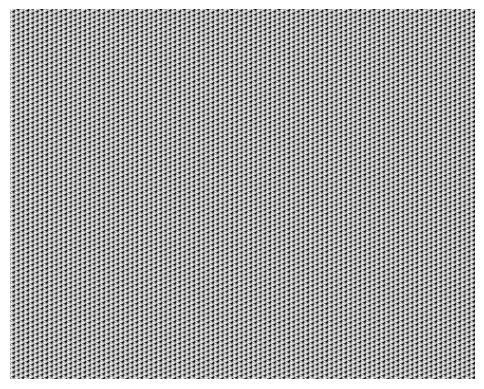

In [4]:
runs1=[]
losses1=[]
for i in range(10):
    print(datetime.now().strftime("%H:%M:%S"))
    K=KmeanVQ(vecs,'K++',C=1)
    K.run(itt=1000)
    runs1.append(K)
    losses1.append(K.Loss(norm=True))
KBest=runs1[np.argmin(losses1)]
comp=[]
for i in range(len(vecs)):
    comp.append(KBest.mu[int(KBest.labels[i])])
img=np.array(comp).reshape(7644,5,5).reshape(h,w)
print('PSNR:',PSNR(np.array(night,dtype='float64'),img*255,data_range=255))
plt.imshow(img*255,cmap='Greys_r')
plt.axis('off')
plt.savefig("Images/Night1.png",bbox_inches='tight',dpi=300)

22:50:50
All Averages Found
Convergence Reached 43  Itterations  22.063994573752555
22:50:54
All Averages Found
Convergence Reached 41  Itterations  22.100337588845314
22:50:58
All Averages Found
Convergence Reached 64  Itterations  22.102204796839448
22:51:04
All Averages Found
Convergence Reached 104  Itterations  22.057785862531786
22:51:13
All Averages Found
Convergence Reached 71  Itterations  22.053621471024157
22:51:19
All Averages Found
Convergence Reached 74  Itterations  22.070480719978256
22:51:26
All Averages Found
Convergence Reached 117  Itterations  22.042102279994364
22:51:35
All Averages Found
Convergence Reached 59  Itterations  22.117266970271544
22:51:40
All Averages Found
Convergence Reached 61  Itterations  22.130390303212693
22:51:46
All Averages Found
Convergence Reached 92  Itterations  22.063951944863398
PSNR: 17.151545493540326


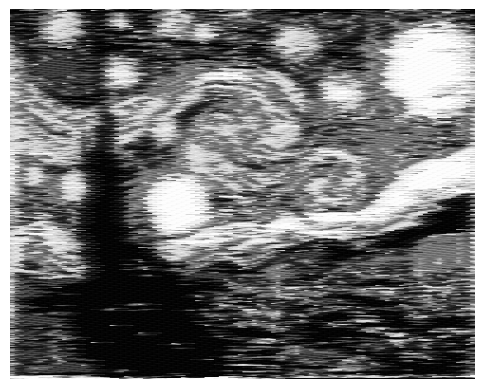

In [5]:
runs10=[]
losses10=[]
for i in range(10):
    print(datetime.now().strftime("%H:%M:%S"))
    K=KmeanVQ(vecs,'K++',C=10)
    K.run(itt=1000)
    runs10.append(K)
    losses10.append(K.Loss(norm=True))
KBest=runs10[np.argmin(losses10)]
comp=[]
for i in range(len(vecs)):
    comp.append(KBest.mu[int(KBest.labels[i])])
img=np.array(comp).reshape(7644,5,5).reshape(h,w)
print('PSNR:',PSNR(np.array(night,dtype='float64'),img*255,data_range=255))
plt.imshow(img*255,cmap='Greys_r')
plt.axis('off')
plt.savefig("Images/Night10.png",bbox_inches='tight',dpi=300)

22:51:54
All Averages Found
Convergence Reached 50  Itterations  15.871626234362772
22:52:15
All Averages Found
Convergence Reached 35  Itterations  15.831926371716888
22:52:34
All Averages Found
Convergence Reached 33  Itterations  15.893867349607826
22:52:51
All Averages Found
Convergence Reached 42  Itterations  15.934215201834838
22:53:11
All Averages Found
Convergence Reached 53  Itterations  15.950103705516243
22:53:32
All Averages Found
Convergence Reached 39  Itterations  15.877218109595434
22:53:51
All Averages Found
Convergence Reached 43  Itterations  15.857701466701846
22:54:10
All Averages Found
Convergence Reached 49  Itterations  15.877950924905162
22:54:30
All Averages Found
Convergence Reached 38  Itterations  15.874728889407669
22:54:49
All Averages Found
Convergence Reached 67  Itterations  15.886354089062564
PSNR: 18.588738011667218


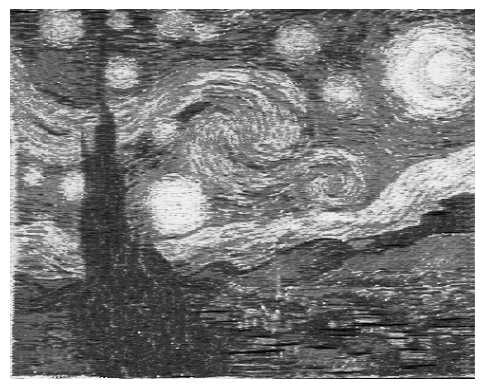

In [6]:
runs100=[]
losses100=[]
for i in range(10):
    print(datetime.now().strftime("%H:%M:%S"))
    K=KmeanVQ(vecs,'K++',C=100)
    K.run(itt=1000)
    runs100.append(K)
    losses100.append(K.Loss(norm=True))
KBest=runs100[np.argmin(losses100)]
comp=[]
for i in range(len(vecs)):
    comp.append(KBest.mu[int(KBest.labels[i])])
img=np.array(comp).reshape(7644,5,5).reshape(h,w)
print('PSNR:',PSNR(np.array(night,dtype='float64'),img*255,data_range=255))
plt.imshow(img*255,cmap='Greys_r')
plt.axis('off')
plt.savefig("Images/Night100.png",bbox_inches='tight',dpi=300)

11:53:28
All Averages Found
Convergence Reached 16  Itterations  9.773240277904174
12:31:04
All Averages Found
Convergence Reached 18  Itterations  9.763496659714225
13:08:28
All Averages Found
Convergence Reached 21  Itterations  9.771640316307985
15:53:10
All Averages Found
Convergence Reached 19  Itterations  9.776241146363778
16:32:05
All Averages Found
Convergence Reached 13  Itterations  9.748631781946699
01:10:30
All Averages Found
Convergence Reached 22  Itterations  9.709070412854647
01:47:44
All Averages Found
Convergence Reached 17  Itterations  9.760226210272013
02:25:06
All Averages Found
Convergence Reached 17  Itterations  9.805938116650818
03:07:45
All Averages Found
Convergence Reached 17  Itterations  9.736173153008288
03:46:53
All Averages Found
Convergence Reached 18  Itterations  9.768245654226416
PSNR: 20.712299119086413


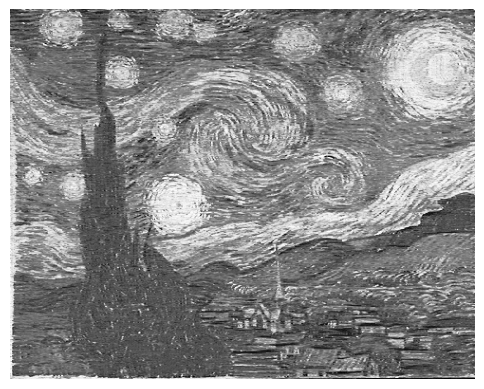

In [8]:
runs1000=[]
losses1000=[]
for i in range(10):
    print(datetime.now().strftime("%H:%M:%S"))
    K=KmeanVQ(vecs,'K++',C=1000)
    K.run(itt=1000)
    runs1000.append(K)
    losses1000.append(K.Loss(norm=True))
KBest=runs1000[np.argmin(losses1000)]
comp=[]
for i in range(len(vecs)):
    comp.append(KBest.mu[int(KBest.labels[i])])
img=np.array(comp).reshape(7644,5,5).reshape(h,w)
print('PSNR:',PSNR(np.array(night,dtype='float64'),img*255,data_range=255))
plt.imshow(img*255,cmap='Greys_r')
plt.axis('off')
plt.savefig("Images/Night1000.png",bbox_inches='tight',dpi=300)